In [4]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as functions

spark = SparkSession.builder\
    .master("spark://192.168.2.59:7077")\
    .appName("test_app")\
    .config("spark.driver.memory","4096m")\
    .config("spark.executor.memory", "2048m")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [5]:
rc = spark.read.format('json').load('hdfs:///reddit_comments')

In [37]:
df_subreddits = rc.groupBy('subreddit')
df_subreddits_count = df_subreddits.count().orderBy("count", ascending=False)
df_subreddits_count.show(5)

+----------+------+
| subreddit| count|
+----------+------+
| AskReddit|875973|
|      pics|487514|
|reddit.com|325653|
|    gaming|244828|
|  politics|243931|
+----------+------+
only showing top 5 rows



In [6]:
# Defines function that counts number of bad words

# Bad words
profanity= ["asshole","bitch","bloody","bollocks","bugger","bullshit","bitch","cock","cocksucker","coonass","cornhole","cracker"
            ,"cunt","dick","dickhead","faggot","fuck","motherfucker","nigga","nigger","paki","pussy","shit","slut","tranny"
            "twat","wanker"]

# Function to count nr profanity in a single comment
def count_profanity(comment):
    count = 0
    for word in comment.split():
        if word.lower() in profanity:
            count += 1
    return count
    
# User defined function boilerplate code
udf_count_profanity = functions.udf(lambda x: count_profanity(x))


In [7]:
# Removes unecessary columns
remove_cols = ["archived","author_flair_css_class","author", "author_flair_text", "controversiality", "created_utc", \
              "distinguished", "downs", "edited", "gilded", "id", "link_id", "name", "parent_id", "removal_reason", \
              "retrieved_on", "score", "score_hidden", "subreddit_id", "ups"]


df_slim = rc.drop(*remove_cols)
df_slim.printSchema()


root
 |-- body: string (nullable = true)
 |-- subreddit: string (nullable = true)



In [8]:
# Count nr bad words for all comments and convert column to int
from pyspark.sql.types import IntegerType

d1 = df_slim.withColumn("bad_words", udf_count_profanity(functions.col("body")))
d2 = d1.drop("body")
d3 = d2.selectExpr("subreddit", "cast(bad_words as int) bad_words")
d3.printSchema()


root
 |-- subreddit: string (nullable = true)
 |-- bad_words: integer (nullable = true)



In [10]:
# Sort by each subreddit and add up bad words 
d4 = d3.groupBy("subreddit").sum("bad_words").sort('sum(bad_words)', ascending=False)
d4.show(5)

+----------+--------------+
| subreddit|sum(bad_words)|
+----------+--------------+
| AskReddit|         39532|
|      pics|         17017|
|reddit.com|         14970|
|  politics|         12873|
|       WTF|         10052|
+----------+--------------+
only showing top 5 rows



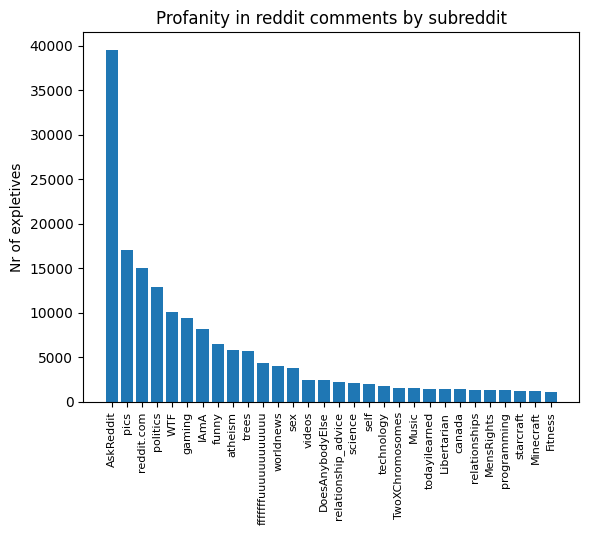

In [35]:
# Plot number of bad words by subreddit
import matplotlib.pyplot as plt

plot_size = 30
subreddits = [x[0] for x in d4.collect()]
nr_bad_words = [x[1] for x in d4.collect()]

 
fig, ax = plt.subplots()


ax.bar(subreddits[0:plot_size], nr_bad_words[0:plot_size])

ax.set_ylabel('Nr of expletives')
ax.set_title('Profanity in reddit comments by subreddit')
plt.xticks(rotation = 90, fontsize=8)
plt.show()



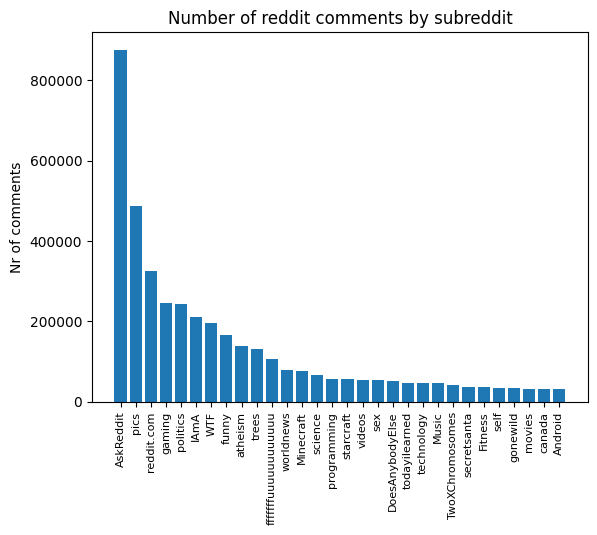

In [42]:
# Plot number of comments by subreddit
import matplotlib.pyplot as plt

plot_size = 30
subreddits_tot = [x[0] for x in df_subreddits_count.collect()]
nr_total_comments = [x[1] for x in df_subreddits_count.collect()]

 
fig, ax = plt.subplots()


ax.bar(subreddits_tot[0:plot_size], nr_total_comments[0:plot_size])

ax.set_ylabel('Nr of comments')
ax.set_title('Number of reddit comments by subreddit')
plt.xticks(rotation = 90, fontsize=8)
plt.show()

In [57]:
# Calculate ratio of expletives / comment for top subreddits
# Since data is already reduced should be fine to use normal python lists & dictionaries

nr_subreddits = 30
subreddits_dict = {} # Use dict to still be correct if order is switched from bad words to total words
for i in range(nr_subreddits):
    sub = subreddits[i]
    subreddits_dict[sub] = nr_bad_words[i]
    
for i in range(nr_subreddits):
    sub = subreddits_tot[i]
    if sub in subreddits_dict:
        subreddits_dict[sub] *= 1/nr_total_comments[i]
        
for key in subreddits_dict:
    val = subreddits_dict[key]
    
bad_word_ratios = [subreddits_dict[key] for key in subreddits_dict]   

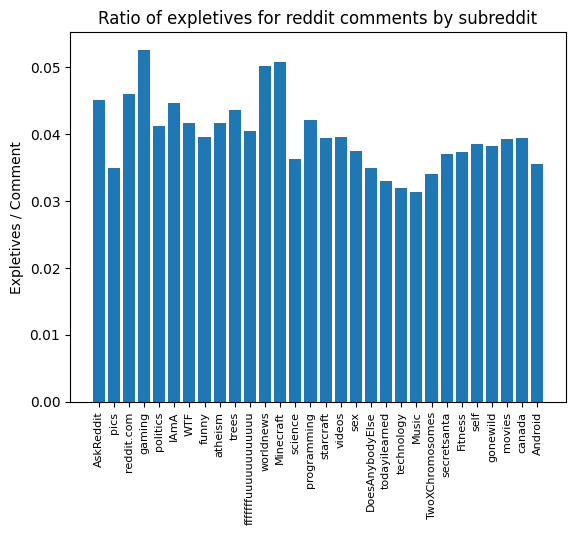

In [58]:
# Plot ratio of bad words / comment
# Depends on calcuations above 
import matplotlib.pyplot as plt

plot_size = 30
fig, ax = plt.subplots()

ax.bar(subreddits[0:plot_size], bad_word_ratios[0:plot_size])

ax.set_ylabel('Expletives / Comment')
ax.set_title('Ratio of expletives for reddit comments by subreddit')
plt.xticks(rotation = 90, fontsize=8)
plt.show()
